### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential



In [7]:
### Load the data and split it into training and testing sets (this is only when runnnig the code in local machine)

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_dir = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration")
    data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
    data_dir_test = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")
else:
    print('Running locally')
    data_dir = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration")
    data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
    data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

Running locally


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Load Training data  as Tensor data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,labels='inferred',label_mode='int',color_mode='rgb',batch_size=batch_size,image_size=(img_height,img_width),shuffle=True,seed=123,validation_split=0.2,subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
#print one row of the dataset
print(type(train_ds))
print(type(train_ds.take(1)))
print(type(list(train_ds.take(1))[0]))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.take_op._TakeDataset'>
<class 'tuple'>


In [12]:
## Validation data set
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,labels='inferred', label_mode='int',color_mode='rgb',batch_size=batch_size,image_size=(img_height,img_width),shuffle=True,seed=123,validation_split=0.2,subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,labels='inferred',label_mode='int',color_mode='rgb',batch_size=batch_size,image_size=(img_height,img_width),shuffle=False,seed=123)

Found 118 files belonging to 9 classes.


In [14]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### visualize one instance of all the nine classes present in the dataset

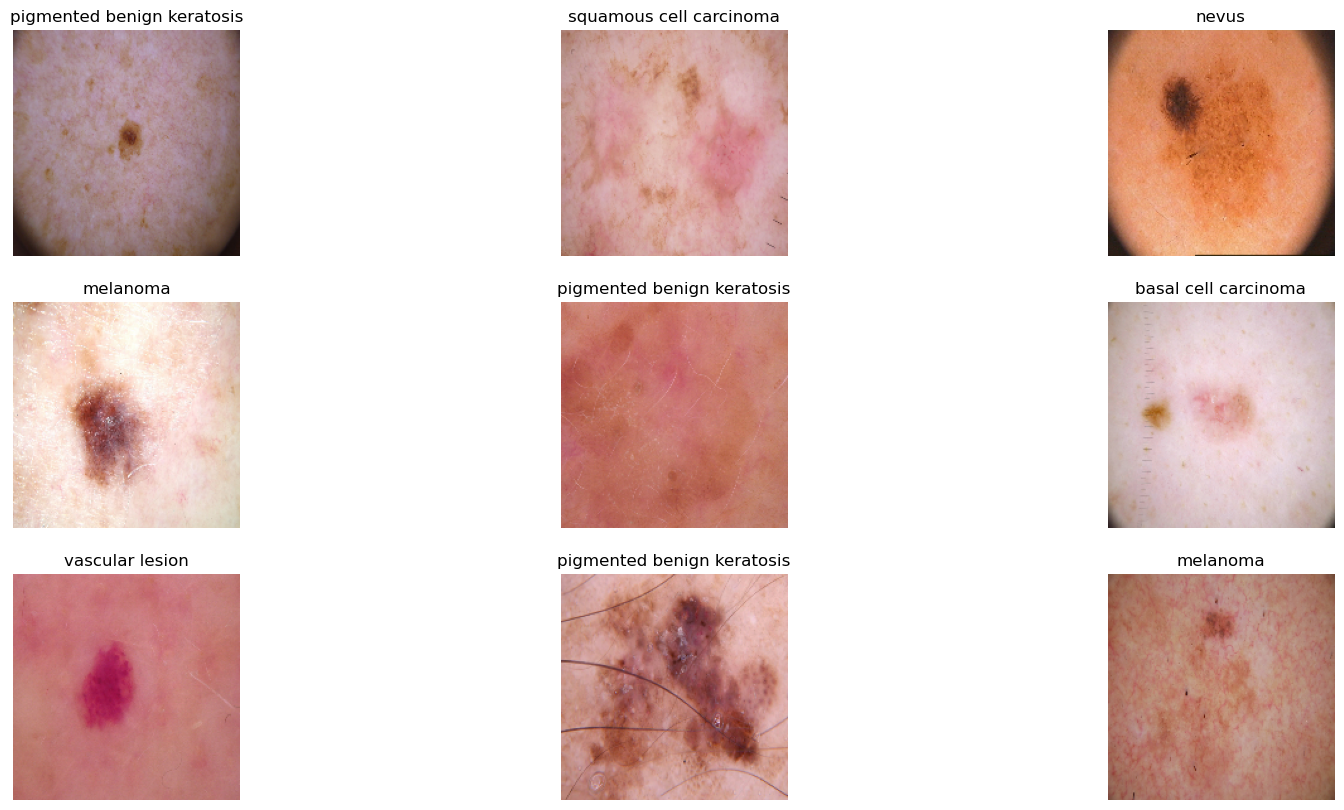

In [15]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize


# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

# Loop through a batch of images and labels from the dataset

for i, (image, label) in enumerate(train_ds.take(9)):
    ax = axes[i // 3, i % 3]
    ax.imshow(image[0].numpy().astype("uint8"))
    ax.set_title(class_names[label[0]])
    ax.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Your code goes here

num_classes = 9

model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())

## Adding Dense Layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))


d:\Conda\envs\mlmodel1\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Summary

1. Activation Functions: The model uses ReLU activation for the hidden layers to introduce non-linearity, and softmax activation for the output layer to produce a probability distribution over the 9 classes.
2. Dropout Layers: The dropout layers help prevent overfitting by randomly setting a fraction of the input units to zero during training.
3. Max-Pooling Layers: These layers downsample the feature maps, reducing the spatial dimensions while preserving the most important features.

### Compile the model
**adam** optimizer :The Adam optimizer (short for Adaptive Moment Estimation) is one of the most commonly used optimization algorithms in deep learning. It combines the advantages of two other popular optimizers, AdaGrad and RMSProp, to create a more effective and adaptive learning algorithm. Adam is particularly useful for training deep neural networks because it dynamically adjusts the learning rate for each parameter based on estimates of first and second moments of the gradients.

**sparse_categorical_crossentropy** is a loss function used in classification problems, especially when the target labels are in integer format rather than one-hot encoded vectors. It is commonly used when dealing with multi-class classification problems where the classes are mutually exclusive.

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,997,481 (15.25 MB)

 Trainable params: 3,997,481 (15.25 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.2199 - loss: 2.1939 - val_accuracy: 0.3691 - val_loss: 1.8459
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.3884 - loss: 1.7261 - val_accuracy: 0.4609 - val_loss: 1.6313
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.4378 - loss: 1.5234 - val_accuracy: 0.4452 - val_loss: 1.5829
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.5020 - loss: 1.4192 - val_accuracy: 0.4720 - val_loss: 1.4517
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.5276 - loss: 1.2962 - val_accuracy: 0.5123 - val_loss: 1.4181
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.5351 - loss: 1.2951 - val_accuracy: 0.5190 - val_loss: 1.3456
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.5848 - loss: 1.2116 - val_accuracy: 0.5481 - val_loss: 1.3562
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.5661 - loss: 1.2083 - val_accuracy: 0

### Visualizing training results

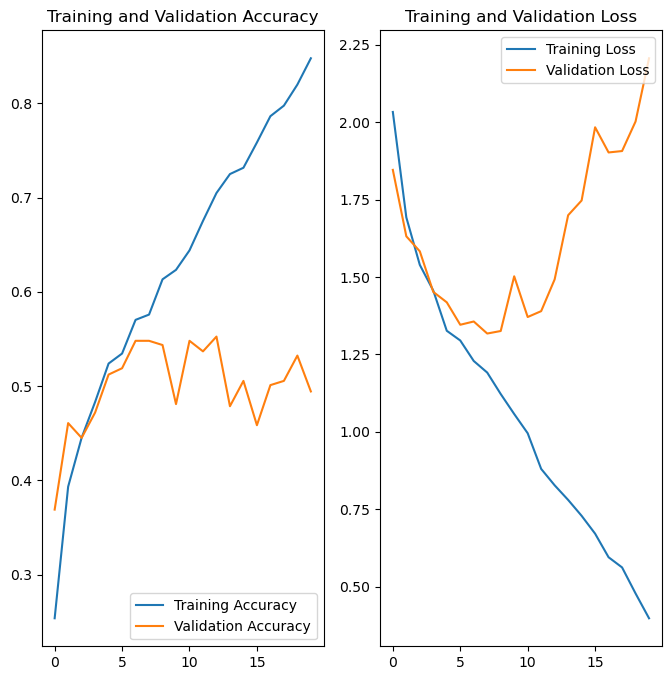

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Finding - Model is underfit, with validation accuracy around 50%

#### Obseravations

1. Training Accuracy Increases Consistently:The training accuracy shows a steady increase as the epochs progress, indicating that the model is learning well from the training data. It reaches a relatively high level by the end of the training process.

2. Validation Accuracy is Lower and More Fluctuating: While the validation accuracy improves initially, it does not rise as steadily as the training accuracy and shows more fluctuations. This suggests that the model may struggle to generalize well on unseen data, potentially due to overfitting.

3. Training Loss Decreases Significantly, but Validation Loss Stagnates:The training loss decreases sharply over the epochs, which is expected as the model learns from the data. However, the validation loss decreases initially but then stagnates or even increases slightly, which is a sign of overfitting — the model performs well on training data but not as well on validation data.


### Create the model by using batch normalization, check if that helps in increasing Validation Accuracy


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization

# Define the number of classes
num_classes = 9

# Create the model
model = Sequential()

# Input Rescaling Layer
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# First Convolutional Block
model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Batch Normalization added
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Second Convolutional Block
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Batch Normalization added
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Third Convolutional Block
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Batch Normalization added
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flattening Layer
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization added
model.add(layers.Dense(64, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization added

# Output Layer
model.add(layers.Dense(num_classes, activation='softmax'))




#### **Model Summary**
1. Overfitting Issues Addressed:The use of Dropout layers helps address overfitting by preventing the model from relying too much on any specific neurons.
2. Batch Normalization improves training stability, speeds up convergence, and may act as a regularizer to reduce overfitting.
3. Generalization Enhancements:Batch Normalization layers ensure that each layer of the network receives normalized input, reducing internal covariate shifts and making the model more robust to changes in the training data.
Model Complexity:

With the combination of Convolutional layers, Dropout, and Batch Normalization, the model balances complexity and regularization, which should help it generalize better to unseen data.

### Compiling the model

In [25]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


### Training the model

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 384ms/step - accuracy: 0.3287 - loss: 2.0430 - val_accuracy: 0.0403 - val_loss: 10.6094
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.5518 - loss: 1.3241 - val_accuracy: 0.0403 - val_loss: 15.8991
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.6538 - loss: 1.0821 - val_accuracy: 0.0403 - val_loss: 15.1361
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - accuracy: 0.6934 - loss: 0.9233 - val_accuracy: 0.0515 - val_loss: 12.0244
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.7418 - loss: 0.7908 - val_accuracy: 0.0470 - val_loss: 9.4295
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.7810 - loss: 0.6624 - val_accuracy: 0.1298 - val_loss: 5.4070
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8726 - loss: 0.4300 - val_accuracy: 0.2103 - val_loss: 4.8136
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.9073 - loss: 0.3057 - val_

### Visualizing the results

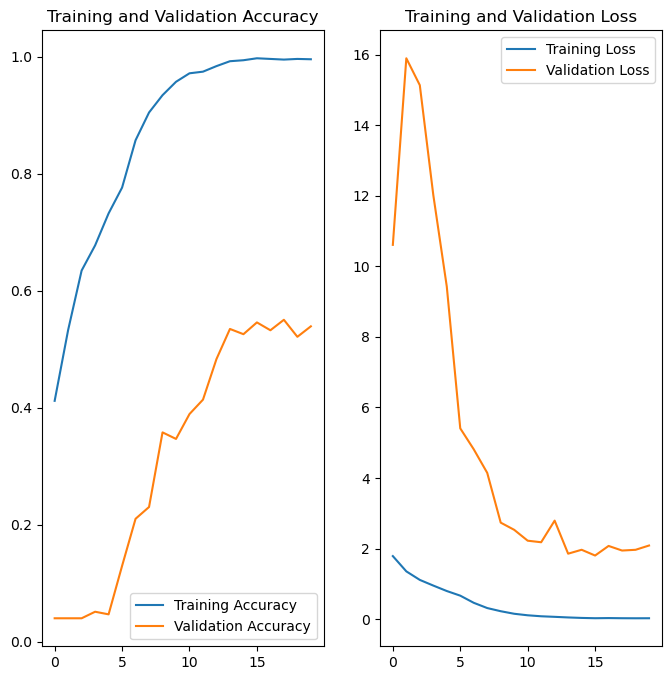

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Observations**
1. Overfitting: The model is likely overfitting the training data. This is indicated by the high training accuracy and low loss, combined with the much lower validation accuracy and high validation loss.
2.Potential Improvements: To address overfitting, you might consider techniques such as:
 * Adding more regularization (e.g., increasing dropout rates or adding L2 * regularization).
 * Gathering more training data or data augmentation.
 * Reducing the complexity of the model.
 * Early stopping during training to prevent the model from learning noise in the data.



### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.

## find the class imbalance in your dataset
labels = []
for _, label_batch in train_ds:
    labels.extend(label_batch.numpy())

unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(class_names, counts)))


{'actinic keratosis': 92, 'basal cell carcinoma': 309, 'dermatofibroma': 77, 'melanoma': 352, 'nevus': 277, 'pigmented benign keratosis': 370, 'seborrheic keratosis': 58, 'squamous cell carcinoma': 142, 'vascular lesion': 115}


##### Not all the classes of Images have same data samples. There is significant variance in image samples. Melanoma has 355 Images and seborrheic keratosis has 59 Images. This shows **Class Imbalance**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 320.0 kB/s eta 0:00:01
     --------------------------- ---------- 41.0/57.6 kB 388.9 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 378.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.4 kB ? eta -:--:--
   ---------------------------------------- 78.4/78.4 kB 2.2 MB/s eta 0:00:00


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
import os
import Augmentor

# Path to the training dataset

path_to_training_dataset = data_dir_train

# Check if the main dataset directory exists
if not os.path.exists(path_to_training_dataset):
    print(f"The directory {path_to_training_dataset} does not exist. Please check the path.")
else:
    print(f"The directory {path_to_training_dataset} exists.")

# Loop through each class and create an Augmentor pipeline
for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)

    # Check if the class subdirectory exists
    if not os.path.exists(class_path):
        print(f"The subdirectory {class_path} does not exist. Please check the class names.")
    else:
        # Create the Augmentor pipeline
        p = Augmentor.Pipeline(class_path)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


The directory Skin cancer ISIC The International Skin Imaging Collaboration\Train exists.
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DF45031690>: 100%|██████████| 500/500 [00:02<00:00, 178.70 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DF470A15D0>: 100%|██████████| 500/500 [00:02<00:00, 180.44 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DF45042050>: 100%|██████████| 500/500 [00:02<00:00, 178.32 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1DF43C79A50>: 100%|██████████| 500/500 [00:13<00:00, 37.02 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DF40909590>: 100%|██████████| 500/500 [00:12<00:00, 40.82 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DF450482D0>: 100%|██████████| 500/500 [00:02<00:00, 184.57 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1DF44FE9750>: 100%|██████████| 500/500 [00:06<00:00, 76.41 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1DF406D8C10>: 100%|██████████| 500/500 [00:03<00:00, 153.66 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DF47180150>: 100%|██████████| 500/500 [00:03<00:00, 148.76 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_02a932c9-360a-46ab-84eb-c7268521e64a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_367dfc5a-2fae-4f1b-9b8a-4cdb126bc849.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_403206c8-de89-46d5-a6a1-58aa7f8eb08b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_54fbf701-be32-428f-8e8d-3fb3b4379b6e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7d074c4b-65f1-455b-94a3-a53e434f29b7.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(x))) for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(lesion_list_new))
set(lesion_list_new)

4500


{'actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion'}

In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [50]:
new_df['Label'].value_counts()

,count
Label,
basal cell carcinoma,500
dermatofibroma,500
vascular lesion,500
pigmented benign keratosis,500
melanoma,500
actinic keratosis,500
squamous cell carcinoma,500
seborrheic keratosis,500
nevus,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
## check if path exists

path_list

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_02a932c9-360a-46ab-84eb-c7268521e64a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_367dfc5a-2fae-4f1b-9b8a-4cdb126bc849.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_403206c8-de89-46d5-a6a1-58aa7f8eb08b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_54fbf701-be32-428f-8e8d-3fb3b4379b6e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7d074c4b-65f1-455b-94a3-a53e434f29b7.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [43]:
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Create New Model:**
Now with data augmentation being done, build new model. Chose approrpiate filters to extract more features

In [49]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization
# import experimental module


# Define the number of classes
num_classes = 9

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

#model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### **Model Summary**
1. Three convolutional layers with increasing complexity (32, 64, and 128 filters) to learn hierarchical features.
2. MaxPooling layers to reduce the spatial size and extract key features.
3. Dropout layers to mitigate overfitting.
4. Dense layers for classification with a final softmax layer to output probabilities.

In [50]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train the model

In [51]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 385ms/step - accuracy: 0.2261 - loss: 2.0496 - val_accuracy: 0.4076 - val_loss: 1.5192
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 397ms/step - accuracy: 0.4058 - loss: 1.5742 - val_accuracy: 0.4321 - val_loss: 1.4864
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 416ms/step - accuracy: 0.4497 - loss: 1.4203 - val_accuracy: 0.5442 - val_loss: 1.2204
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 69s 409ms/step - accuracy: 0.5280 - loss: 1.2622 - val_accuracy: 0.5694 - val_loss: 1.1299
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 399ms/step - accuracy: 0.5751 - loss: 1.1205 - val_accuracy: 0.6496 - val_loss: 0.9480
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 398ms/step - accuracy: 0.6185 - loss: 0.9993 - val_accuracy: 0.6288 - val_loss: 0.9518
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 399ms/step - accuracy: 0.6700 - loss: 0.9041 - val_accuracy: 0.6370 - val_loss: 0.9014
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 394ms/step - accuracy: 0.6889 - loss: 0

### **Training and Validation accuracy is around 80%**

#### **Todo:**  Visualize the model results

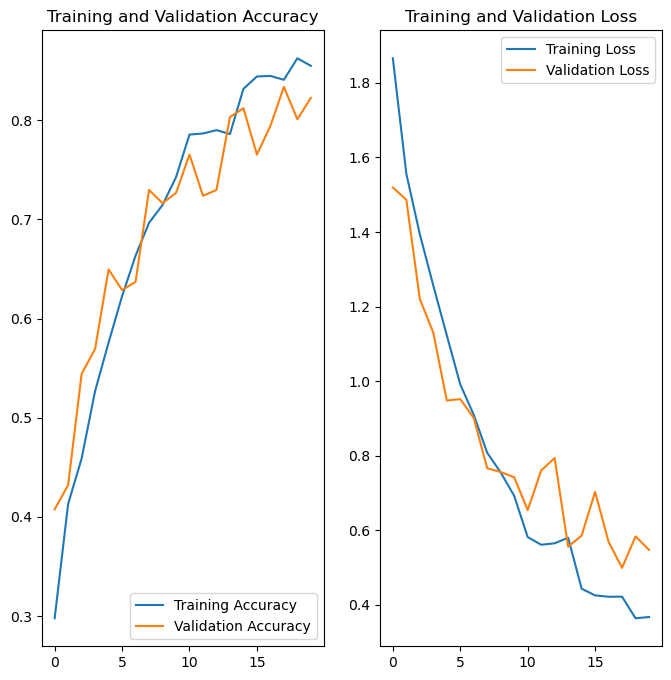

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 **Validation Accuracy and Training Accuracy are similar and above 80%. No Underfitting and Overfittingg**

Observations:
1. Both training and validation loss decrease steadily over the epochs.
2. The training and validation loss are close to each other, which again indicates that the model is learning well and not overfitting.
3. The gradual decrease in loss suggests that the model's performance improves as it trains for more epochs.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Actual Class basal cell carcinoma
Predictive Class pigmented benign keratosis


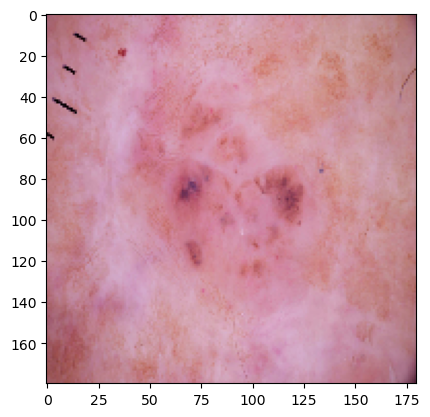

In [53]:
### Model Prediction

from glob import glob
from tensorflow.keras.utils import load_img
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

## **Overall Summary**

Totally 3 models were built. The thid model gave best Training and Validation Accuarcy. **Data Augmentation was performed to handle Class Imablance**. Model complexity was reduced and hyperparameter tuning (dropout layers) were added to control overfitting of model.

**Final CNN Model consists of:**
1. Three convolutional layers with increasing filters (32, 64, 128).
2. Max-pooling layers after each convolutional layer to reduce the spatial dimensions.
3. Dropout layers to prevent overfitting.
4. Dense layers to perform classification with the final output using a softmax activation for multi-class classification.